<a href="https://colab.research.google.com/github/rutasnim/Delivery_Duration_Prediction/blob/main/DeliverytimePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delievery Duration Prediction


When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

* Start: the time consumer submits the order (`created_at`) to
* End: when the order will be delivered to the consumer (`actual_delivery_time`)


## Importing the Packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

## Getting the data 

In [2]:
#Mounting at google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#unzipping the files for the datasets
!unzip gdrive/My\ Drive/datasets/doordash.zip

Archive:  gdrive/My Drive/datasets/doordash.zip
replace datasets/historical_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!head -n 3 datasets/historical_data.csv

"market_id","created_at","actual_delivery_time","store_id","store_primary_category","order_protocol","total_items","subtotal","num_distinct_items","min_item_price","max_item_price","total_onshift_dashers","total_busy_dashers","total_outstanding_orders","estimated_order_place_duration","estimated_store_to_consumer_driving_duration"
"1",2015-02-06 22:24:17,2015-02-06 23:27:16,"1845","american","1",4,3441,4,557,1239,33,14,21,446,861
"2",2015-02-10 21:49:25,2015-02-10 22:56:29,"5477","mexican","2",1,1900,1,1400,1400,1,2,2,446,690


In [5]:
#load data in a datframe
data= pd.read_csv("datasets/historical_data.csv")
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [7]:
# Change the datatype for created_at and actual delivery time
data["created_at"]=pd.to_datetime(data["created_at"])
data["actual_delivery_time"]=pd.to_datetime(data["actual_delivery_time"])


### Feature creation

Actual total delivery duration
(`target_variable`) = `actual delivery time` - `order creation time`

In [8]:
# Create the target variable actual_total_delievery duration for regression 
data["actual_total_delivery duration"]= (data["actual_delivery_time"] - data["created_at"]).dt.total_seconds()


It is helpful to have data on number of available and busy dashers at the time the order was created. Total number of available dashers within a certain area will change from time to time. To make the dashers number more comparable, we created the following variable: 

`busy dashers ratio` = `total busy dashers`/ `total onshift dashers`

In [9]:
data["busy_dashers_ratio"]= data["total_busy_dashers"]/ data["total_onshift_dashers"]

### Hypothesis:
higher the busy dashers ratio, lesser the dasher capacity, hence deleivery duration will be longer

another feature is no_prep_duration is calculated 

In [10]:
data["estimated_non_prep_duration"]= data["estimated_order_place_duration"] + data["estimated_store_to_consumer_driving_duration"]

## Data Preparation for Modeling 

### One-hot encoding

Check ids and decide whether to encode or not

In [11]:
data["market_id"].nunique()

6

In [12]:
data["store_id"].nunique()

6743

In [13]:
data["order_protocol"].nunique()

7

Looks like we can encode market_id and order_protocol but definitely not store_id

In [14]:
# converting catergorical values into 0s and 1s 
order_protocol_dummies = pd.get_dummies(data.order_protocol)
order_protocol_dummies= order_protocol_dummies.add_prefix('order_protocol_')

market_id_dummies = pd.get_dummies(data.market_id)
market_id_dummies= market_id_dummies.add_prefix('market_id_')

In [15]:
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [16]:
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


From our earlier inspection on store_category, this column has missing values. We will create a reference dictionary. We will map each store id to the most frequent cuisine category they serve AND try to fill the null values where possible

In [17]:
#create dictionary with most repeated categories of each store to fill null rows where it is possible
store_id_unique = data["store_id"].unique().tolist()
store_id_and_category= {store_id: data[data.store_id==store_id].store_primary_category.mode()
                        for store_id in store_id_unique}

In [18]:
def fill(store_id):
  """return primary store id from the dictionary"""
  try:
    return store_id_and_category[store_id][0]
  except:
    return np.nan
#fill null values
data['nan_free_store_primary_category']=data.store_id.apply(fill)

In [19]:
#create dummies for store primary category
store_primary_category_dummies= pd.get_dummies(data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df= data.drop(columns= ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                              "nan_free_store_primary_category", "order_protocol"])
train_df.head()
                    

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery duration,busy_dashers_ratio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [21]:
#concat all columns 
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)

In [22]:
#align dtype over  dataset
train_df = train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.666546,1823.093750,1.630255,522.038635,558.411377,34.526787,32.145733,52.661831,90.139648,219.352905,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
train_df["busy_dashers_ratio"].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

Get rid of infite values(divide by zero.)

In [25]:
#check infinity values with using numpy isfinite() function

In [26]:
np.where(np.any(~np.isfinite(train_df), axis=0)==True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [27]:
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace= True)

#drop all nan
train_df.dropna(inplace= True)

In [28]:
train_df.shape

(177070, 100)

## Removing Redundancy and Collinearity

Colinear features 
Colinearity means that the variables are correlated with each other. Both of the variables has the same effect on the model

In [29]:
# correlation matrix with a mask
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

<Axes: >

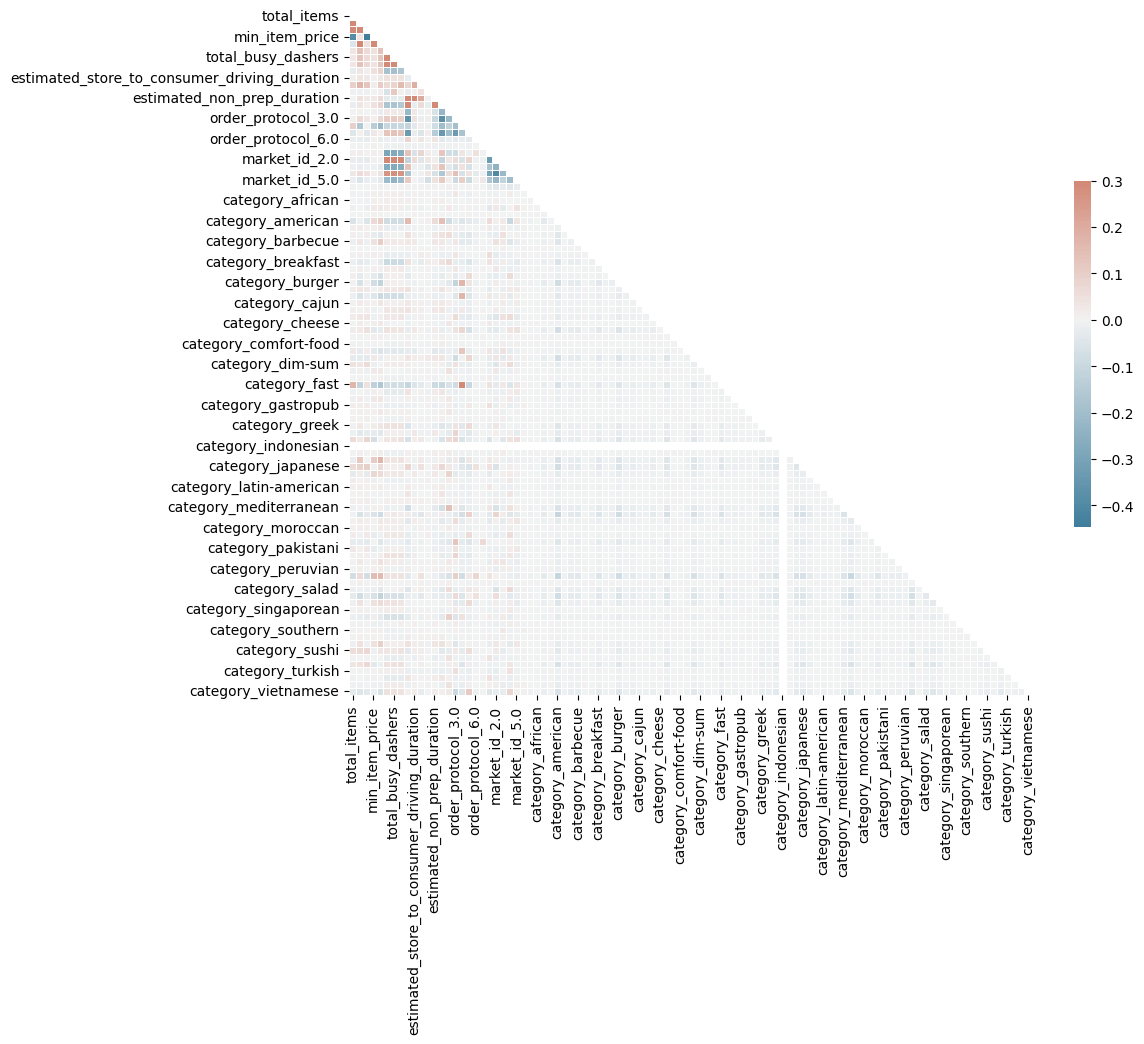

In [30]:
#set up the matplotlib figure
f, ax= plt.subplots(figsize=(11,9))
#generate a custom diversing colormap
cmap= sns.diverging_palette(230,20, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax= .3, center=0,
            square= True, linewidths=.5, cbar_kws={"shrink": .5})

Catergory indosian got issuses 

In [31]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

Two functions to test the correlations:
1. Get redundant values
2. find top correlated features

In [32]:
def get_redundant_pairs(df):
  """ Get diagonal and lower triangular pairs of correlation matrix"""
  pairs_to_drop =set()
  cols=df.columns
  for i in range(0, df.shape[1]):
    for j in range(0, i+1):
      pairs_to_drop.add((cols[i],cols[j]))
  return pairs_to_drop

In [33]:
def get_top_abs_correlations(df, n=5):
  """sort correlations in the descending order and return n highest results"""
  au_corr= df.corr().abs().unstack()
  labels_to_drop=get_redundant_pairs(df)
  au_corr= au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
  return au_corr[0:n]

In [34]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

In [35]:
#drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df= data.drop(columns= ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                              "nan_free_store_primary_category", "order_protocol"])
#don't concat market_id
train_df = pd.concat([train_df, order_protocol_dummies,store_primary_category_dummies], axis=1)
#drop highly correlated features
train_df= train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                 "category_indonesian",
                                 "estimated_non_prep_duration"])
#align dtype over  dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace= True)
#drop all nan
train_df.dropna(inplace= True)

In [36]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
train_df.shape

(177070, 90)

In [38]:
def get_top_abs_correlations(df, n=5):
  """sort correlations in the descending order and return n highest results"""
  au_corr= df.corr().abs().unstack()
  labels_to_drop=get_redundant_pairs(df)
  au_corr= au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
  return au_corr[0:n]
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

order protol

In [39]:
#drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df= data.drop(columns= ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                              "nan_free_store_primary_category", "order_protocol"])
#don't concat order_protocol
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)
#drop highly correlated features
train_df= train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                 "category_indonesian",
                                 "estimated_non_prep_duration"])
#align dtype over  dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace= True)
#drop all nan
train_df.dropna(inplace= True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery duration    0.188418
subtotal                                      actual_total_delivery duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

### Feature Engineering

In [41]:
#new features 
train_df["percent_distinct_item_of_total"]= train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"]=train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

In [42]:
train_df["price_range_of_items"]= train_df["max_item_price"]- train_df["min_item_price"]
train_df.drop(columns=["max_item_price","min_item_price"], inplace= True)

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery duration    0.15

In [43]:
train_df.shape

(177070, 82)

## Multicolinearity and feature selection
multicolinearity is when one predictor variable in a multiple regression model can be predicted from the other variables 

VIF factor

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [45]:
def compute_vif(feautures):
  """compute VIF score using variance_inflation_factor() function"""
  vif_data= pd.DataFrame()
  vif_data["feature"]= feautures 
  vif_data["VIF"]= [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
  return vif_data.sort_values(by=['VIF']).reset_index(drop=True)


In [46]:
#apply VIF computation to all columns
features= train_df.drop(columns=["actual_total_delivery duration"]).columns.to_list()
vif_data= compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000498
2,category_belgian,1.000760
3,category_russian,1.003231
4,category_african,1.003823
...,...,...
76,busy_dashers_ratio,6.369601
77,category_american,7.033604
78,estimated_store_to_consumer_driving_duration,7.210844
79,estimated_order_place_duration,13.472280


In [47]:
multicollinearity = True

while multicollinearity:
  highest_vif_feature = vif_data['feature'].values.tolist()[-1]
  print("I will remove", highest_vif_feature)
  features.remove(highest_vif_feature)
  vif_data = compute_vif(features)
  multicollinearity = False if len(vif_data[vif_data.VIF >20])== 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data


I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000369
2,category_belgian,1.000461
3,category_russian,1.002022
4,category_gluten-free,1.002372
...,...,...
75,category_american,4.505928
76,avg_price_per_item,5.958972
77,busy_dashers_ratio,6.357889
78,estimated_store_to_consumer_driving_duration,7.192644


## Feature selection

### Random Forest regression model
Apply random forest regression methood to find the gini importance 

Gini importance calculates the features importance across all split that random forest regression model to do

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#selected featured are selected in multicollinearity check part
X = train_df[selected_features]
y = train_df["actual_total_delivery duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state= 42)

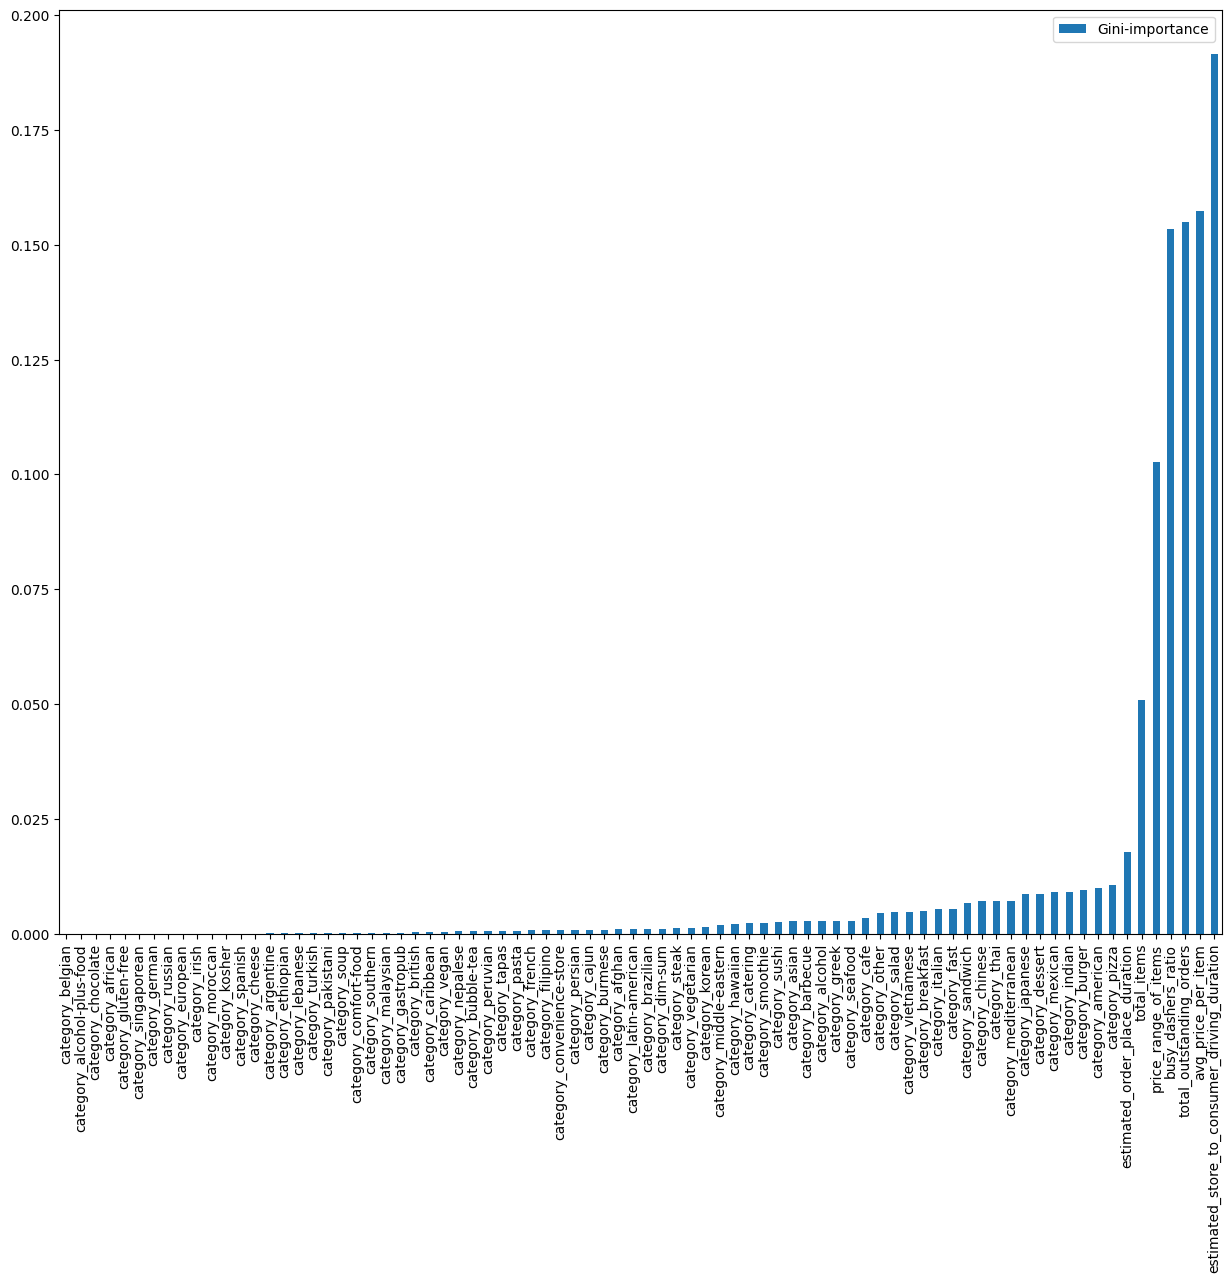

In [49]:
feature_names = [f"feature{i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats={} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
  feats[feature]= importance #add the name/ value pair
importances = pd.DataFrame.from_dict(feats, orient= 'index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot= 90, figsize=(15,12))
plt.show()

In [50]:
# we can obtain the column names as text
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

#### PCA 
Another dimension reduction technique to regression tasks and also removes multicolinearity

<ipython-input-51-763e571ec37a>:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


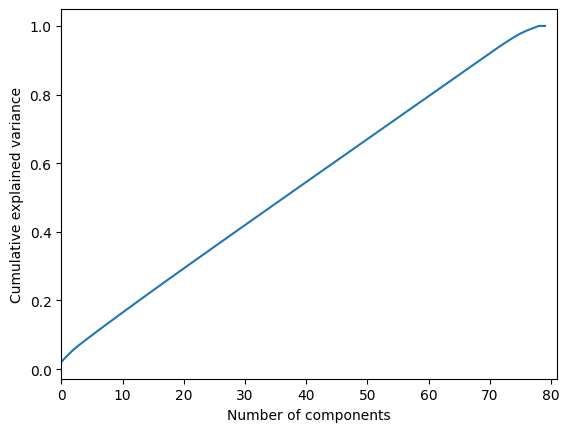

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train = X_train.values
X_train = np.asarray(X_train)

# Finding normalized array of X_train
X_std= StandardScaler().fit_transform(X_train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Result tells us by using 60% of the features dataset can be explained 80%

### Feature scaling

Scaling 
standard scaler and min max scaler

In [52]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [53]:
def scale(scaler, X, y):
  """ Apply the selected scaler to features and target variables"""
  X_scaler = scaler
  X_scaler.fit(X=X, y=y)
  X_scaled = X_scaler.transform(X)
  y_scaler = scaler
  y_scaler.fit(y.values.reshape(-1,1))
  y_scaled = y_scaler.transform(y.values.reshape(-1,1))
  return X_scaled, y_scaled, X_scaler, y_scaler

In [54]:
X_scaled, y_scaled, X_scaler, y_scaler =scale(MinMaxScaler(), X, y)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size =0.2, random_state=42)

In [55]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
  """ convert the scaled error to actual error"""
  y_predict= scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
  #return RMSE with squared false
  rmse_error = mean_squared_error(y_test, y_predict[:,0], squared= False)
  print("Error ="'{}'.format(rmse_error)+" in" +model_name)
  return rmse_error, y_predict


## Modeling

Apply classical machine learning techniques to find the best model performance


We will apply 6 different algorithms, 4 different dataset sizes
full( 40, 20 and 10 features,selected by GINIs importance) and 3 different scalers- standard, min-max and no scaler. We will get 6x4x3=72 different results.

In [56]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

In [57]:
#create a generic function which can work with multiple machine learning models
def make_regression( X_train, y_train, X_test, y_test, model, model_name, verbose = True):
  """ apply selected regression model to data and measure error"""
  model.fit(X_train, y_train)
  y_predict= model.predict(X_train)
  train_error = mean_squared_error(y_train, y_predict, squared = False)
  y_predict= model.predict(X_test)
  test_error = mean_squared_error(y_test, y_predict, squared = False)
  if verbose:
    print("Train error ="'{}'.format(train_error)+ " in "+ model_name)
    print("Test error="'{}'.format(test_error)+ "in "+ model_name)
  trained_model= model

  return trained_model, y_predict, train_error, test_error

In [58]:
# 4 different dictionaries containing different parameters 

pred_dict ={
    "regression_model":[],
    "feature_set":[],
    "scaler_name":[],
    "RMSE":[],
     
}

regression_models= {
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

feature_sets ={
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(),
}

scalers={
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

In [59]:

# examine the error for each combination 

for feature_set_name in feature_sets.keys():
  feature_set = feature_sets[feature_set_name]
  for scaler_name in scalers.keys():
    print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
    print("")
    for model_name in regression_models.keys():
      if scaler_name == "NotScale":
        X= train_df[feature_set]
        y = train_df["actual_total_delivery duration"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        make_regression(X_train, y_train, X_test, y_test, regression_models[model_name],model_name, verbose= True)
      else:
        X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled =train_test_split(X_scaled, y_scaled, test_size= 0.2, random_state=42)
        _, y_predict_scaled, _, _ =make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name],
                                                   model_name, verbose= False)
        rmse_error, y_predict= rmse_with_inv_transform(y_scaler,y_test, y_predict_scaled, model_name)
      pred_dict["regression_model"].append(model_name)
      pred_dict["feature_set"].append(feature_set_name)
      pred_dict["scaler_name"].append(scaler_name)
      pred_dict["RMSE"].append(rmse_error)
 


-----scaled with Standard scaler-------- included columns are full dataset

Error =2053.698486328125 inRidge
Error =2057.2476687088733 inDecisionTree
Error =2048.996731917964 inRandomForest
Error =2036.2498779296875 inXGBoost
Error =2033.4355809987908 inLGBM
Error =2038.7890625 inMLP
-----scaled with MinMax scaler-------- included columns are full dataset

Error =2053.962890625 inRidge
Error =2057.2476685732177 inDecisionTree
Error =2047.3044248166798 inRandomForest
Error =2035.351318359375 inXGBoost
Error =2034.4499976619875 inLGBM
Error =2113.24169921875 inMLP
-----scaled with NotScale-------- included columns are full dataset



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.42528e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error =1071.4971923828125 in Ridge
Test error=2053.692626953125in Ridge
Train error =1067.7815291116704 in DecisionTree
Test error=2057.2476684096064in DecisionTree
Train error =396.7493065197635 in RandomForest
Test error=2048.3342525319495in RandomForest
Train error =968.2471313476562 in XGBoost
Test error=2036.43212890625in XGBoost
Train error =1017.5549840201221 in LGBM
Test error=2034.461097275308in LGBM


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error =1058.150146484375 in MLP
Test error=2050.367431640625in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

Error =2054.00439453125 inRidge
Error =2056.5292024696128 inDecisionTree
Error =2048.066339680843 inRandomForest
Error =2035.453369140625 inXGBoost
Error =2034.6538984910121 inLGBM
Error =2035.9691162109375 inMLP
-----scaled with MinMax scaler-------- included columns are selected_features_40

Error =2054.27734375 inRidge
Error =2056.5292023632996 inDecisionTree
Error =2048.4749837156733 inRandomForest
Error =2034.2847900390625 inXGBoost
Error =2035.196536738781 inLGBM
Error =2160.89111328125 inMLP
-----scaled with NotScale-------- included columns are selected_features_40



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.55922e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error =1072.35498046875 in Ridge
Test error=2054.00439453125in Ridge
Train error =1067.785563647774 in DecisionTree
Test error=2056.529202224364in DecisionTree
Train error =395.1461166234845 in RandomForest
Test error=2050.016473898188in RandomForest
Train error =965.6858520507812 in XGBoost
Test error=2035.7642822265625in XGBoost
Train error =1017.1430421117441 in LGBM
Test error=2034.8058530174258in LGBM


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error =1055.0325927734375 in MLP
Test error=2047.0386962890625in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

Error =2055.36572265625 inRidge
Error =2054.610311207463 inDecisionTree
Error =2048.0320348239684 inRandomForest
Error =2037.6336669921875 inXGBoost
Error =2036.0233846729805 inLGBM
Error =2038.0460205078125 inMLP
-----scaled with MinMax scaler-------- included columns are selected_features_20

Error =2055.653076171875 inRidge
Error =2054.6103112689557 inDecisionTree
Error =2050.033346100774 inRandomForest
Error =2036.5164794921875 inXGBoost
Error =2035.581516471472 inLGBM
Error =2079.73974609375 inMLP
-----scaled with NotScale-------- included columns are selected_features_20

Train error =1074.506591796875 in Ridge
Test error=2055.36572265625in Ridge


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.43857e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error =1069.1350906055598 in DecisionTree
Test error=2054.610311170708in DecisionTree
Train error =397.6052651423816 in RandomForest
Test error=2047.5613062292198in RandomForest
Train error =966.1651000976562 in XGBoost
Test error=2036.249267578125in XGBoost
Train error =1018.9600610110249 in LGBM
Test error=2035.9494403356318in LGBM


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error =1057.3758544921875 in MLP
Test error=2048.465576171875in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

Error =2056.568359375 inRidge
Error =2054.5971761770547 inDecisionTree
Error =2052.1195617990766 inRandomForest
Error =2040.27001953125 inXGBoost
Error =2038.1313604554389 inLGBM
Error =2039.4803466796875 inMLP
-----scaled with MinMax scaler-------- included columns are selected_features_10

Error =2056.882080078125 inRidge
Error =2054.5971762373274 inDecisionTree
Error =2051.3622104084766 inRandomForest
Error =2039.515625 inXGBoost
Error =2037.6564489201091 inLGBM
Error =2095.604736328125 inMLP
-----scaled with NotScale-------- included columns are selected_features_10

Train error =1076.7279052734375 in Ridge
Test error=2056.568359375in Ridge
Train error =1069.2324011708552 in DecisionTree
Test error=2054.597176140608in DecisionTree
Train error =401.552739991856 in RandomForest
Test error=2051.9545510141834in RandomForest
Train 

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [60]:
pred_df = pd.DataFrame(pred_dict)

In [61]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,2053.698486
1,DecisionTree,full dataset,Standard scaler,2057.247669
2,RandomForest,full dataset,Standard scaler,2048.996732
3,XGBoost,full dataset,Standard scaler,2036.249878
4,LGBM,full dataset,Standard scaler,2033.435581
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2095.604736
68,RandomForest,selected_features_10,NotScale,2095.604736
69,XGBoost,selected_features_10,NotScale,2095.604736
70,LGBM,selected_features_10,NotScale,2095.604736


<Axes: >

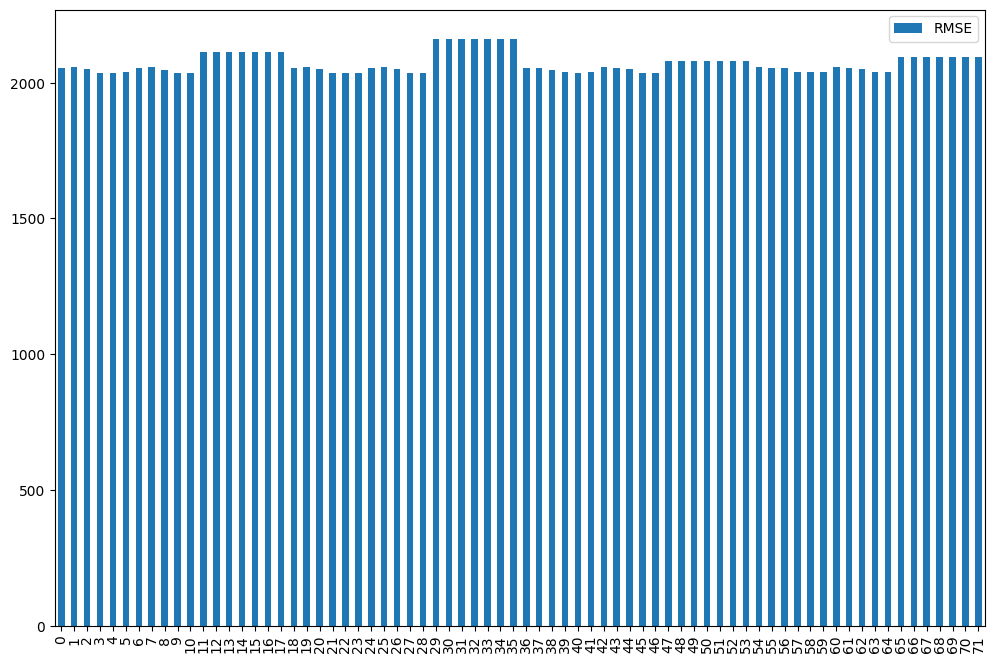

In [62]:
pred_df.plot(kind='bar', figsize=(12,8))


### Output
- High errors through all models. 
- Using different scalars does not have much effect on the models. That's we will be using standard scalers.
- Different fetaure sizes has very slight effect on the model. Therefore, we will continue with 40 selected features


Lets change the problem a little bit by predicting `prep_duration` and then calculate actual_total_delivery_duration after the prediction.

In [63]:
train_df["prep_time"]= train_df["actual_total_delivery duration"]-train_df["estimated_store_to_consumer_driving_duration"]- train_df["estimated_order_place_duration"]

In [64]:
#not scaling affects the performance, so continue to scale but it diesnt matter which scaler we used

scalers= {
    "standard scaler": StandardScaler(),

}

feature_sets={
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}



In [65]:
for feature_set_name in feature_sets.keys():
  feature_set = feature_sets[feature_set_name]
  for scaler_name in scalers.keys():
    print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
    print("")
    for model_name in regression_models.keys():
      #drop "estimated_store_to_consumer_driving_duration" and 
      X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration","estimated_order_place_duration"])

      y = train_df["prep_time"]

      #to get indices
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
      train_indices= X_train.index
      test_indices = X_test.index

      #scale
      X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

      #apply indexing
      X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled =train_test_split(X_scaled, y_scaled, test_size= 0.2, random_state=42)
      _, y_predict_scaled, _, _ =make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name],
                                                   model_name, verbose= True)
      rmse_error, y_predict= rmse_with_inv_transform(y_scaler,y_test, y_predict_scaled, model_name)
      pred_dict["regression_model"].append(model_name)
      pred_dict["feature_set"].append(feature_set_name)
      pred_dict["scaler_name"].append(scaler_name)
      pred_dict["RMSE"].append(rmse_error)
 





-----scaled with standard scaler-------- included columns are selected_features_40

Train error =0.786737859249115 in Ridge
Test error=1.5045511722564697in Ridge
Error =2055.40771484375 inRidge
Train error =0.7693331400114065 in DecisionTree
Test error=1.4976355980472322in DecisionTree
Error =2045.9600605629953 inDecisionTree
Train error =0.2971594439305121 in RandomForest
Test error=1.5019036353890898in RandomForest
Error =2051.7907410656903 inRandomForest
Train error =0.7115257978439331 in XGBoost
Test error=1.4916772842407227in XGBoost
Error =2037.8203125 inXGBoost
Train error =0.7484992880216514 in LGBM
Test error=1.490142572482501in LGBM
Error =2035.7236370573405 inLGBM
Train error =0.7582009434700012 in MLP
Test error=1.49210524559021in MLP
Error =2038.40478515625 inMLP


**LGBM performs better than the others. We will choose LGBM model and repeat the calculation again**

In [66]:
# continue with best performance model

regression_models={
    "LGBM": LGBMRegressor(),
    
}
for feature_set_name in feature_sets.keys():
  feature_set = feature_sets[feature_set_name]
  for scaler_name in scalers.keys():
    print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
    print("")
    for model_name in regression_models.keys():
      #drop "estimated_store_to_consumer_driving_duration" and 
      X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration","estimated_order_place_duration"])

      y = train_df["prep_time"]

      #to get indices
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
      train_indices= X_train.index
      test_indices = X_test.index

      #scale
      X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

      #apply indexing
      X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled =train_test_split(X_scaled, y_scaled, test_size= 0.2, random_state=42)
      _, y_predict_scaled, _, _ =make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name],
                                                   model_name, verbose= True)
      rmse_error, y_predict= rmse_with_inv_transform(y_scaler,y_test, y_predict_scaled, model_name)
      pred_dict["regression_model"].append(model_name)
      pred_dict["feature_set"].append(feature_set_name)
      pred_dict["scaler_name"].append(scaler_name)
      pred_dict["RMSE"].append(rmse_error)
 

-----scaled with standard scaler-------- included columns are selected_features_40

Train error =0.7484992880216514 in LGBM
Test error=1.490142572482501in LGBM
Error =2035.7236370573405 inLGBM


In [67]:
#choose best performance model and extract the predictions for preparation duration

pred_values_dict ={
    "actual_total_delivery duration": train_df["actual_total_delivery duration"][test_indices].values.tolist(),
    "prep_duration_prediction": y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),

}

In [68]:
#convert it to dataframe from dict
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


In [69]:
# sum predictions up with non preparation activities such as order placing and driving
values_df["sum_total_delivery_duration"]= values_df["prep_duration_prediction"]+ values_df["estimated_store_to_consumer_driving_duration"]+ values_df["estimated_order_place_duration"]


In [70]:
values_df

,actual_total_delivery duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


In [71]:
#check new error rate
mean_squared_error(values_df["actual_total_delivery duration"], values_df["sum_total_delivery_duration"])

4144170.7264739666

#### Error is still high. Let's use our predicted prep duration, estimated_store_to_consumer_driving_duration and estimated_order_place_duration to predict actual total delivery duration

In [72]:
# what if we use another regression to obtain the actual total delivery duration?
X = values_df[["prep_duration_prediction","estimated_store_to_consumer_driving_duration","estimated_order_place_duration"]]
y = values_df["actual_total_delivery duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
regression_models= {
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

for model_name in regression_models.keys():
  _, y_predict, _, _ =make_regression(X_train, y_train, X_test, y_test, regression_models[model_name],
                                                   model_name, verbose= False)
  print("RMSE of", model_name, mean_squared_error(y_test,y_predict, squared=False))



RMSE of Ridge 986.6912510344928
RMSE of DecisionTree 1235.578088153976
RMSE of RandomForest 1344.894460883377
RMSE of XGBoost 1370.412425918564
RMSE of LGBM 1079.2949179771774
RMSE of MLP 987.0710367704598


This has been our best solutions.